<a href="https://colab.research.google.com/github/usuario3pm/Predicci-on-de-Niveles-de-Glucosa-en-Sangre-para-la-Diabetes-Tipo-1/blob/main/ProyectML_actualizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursos y librerias

In [ ]:
# Recursos
import time
import warnings

# Manipulación de datos
import pandas as pd  #DataFrames y Series.
import numpy as np

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# División de datos
from sklearn.model_selection import train_test_split

# Modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, r2_score

# Visualización y graficas
import matplotlib.pyplot as plt

# Deep Learning
import torch

# Suprimir advertencias
warnings.filterwarnings('ignore')


# Funciones

In [ ]:
#Calculo errores
def Error(y_real, y_pred):
    """
    Calcula métricas de error comunes para evaluar el modelos de predicción.

    Parámetros:
    - y_real: array-like, valores reales (observados).
    - y_pred: array-like, valores predichos por el modelo.

    Retorna:
    - una tupla con las métricas:  MAE, MAPE, MSE, RMSE, R2 y EVR.
    """
    # Convertir a arrays de NumPy
    y_real = np.array(y_real, dtype=np.float64)
    y_pred = np.array(y_pred, dtype=np.float64)

    # Validación de dimensiones
    if y_real.shape != y_pred.shape:
        raise ValueError("Las dimensiones de y_real y y_pred no coinciden.")

    # MAE (Error absoluto medio)
    mae = np.mean(np.abs(y_real - y_pred))

    # MAPE (Error porcentual absoluto medio)
    mape = np.mean(np.abs((y_real - y_pred) / np.where(y_real == 0, 1, y_real))) * 100  # Evita división por cero

    # MSE (Error cuadrático medio)
    mse = np.mean((y_real - y_pred) ** 2)

    # RMSE (Raíz del error cuadrático medio)
    rmse = np.sqrt(mse)

    # R2 (Coeficiente de determinación)
    ss_total = np.sum((y_real - np.mean(y_real)) ** 2)
    ss_residual = np.sum((y_real - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    # EVR (Varianza explicada)
    var_real = np.var(y_real)
    var_error = np.var(y_real - y_pred)
    evr = 1 - (var_error / var_real)

    # Retornar métricas
    return mae,mape, mse,rmse, r2, evr

# encoder manual
def encode_activities_manual(train_df, test_df, activity_cols):
    """
    Codifica manualmente columnas categóricas en enteros.

    Parámetros:
    - train_df: DataFrame de entrenamiento
    - test_df: DataFrame de prueba (puede ser None)
    - activity_cols: Lista de columnas categóricas a codificar

    Retorna:
    - DataFrames modificados con actividades codificadas.
    """

    # valores únicos
    all_activities = set(['missing'])  # Incluye un valor para manejar los nulos
    for col in activity_cols:
        all_activities.update(train_df[col].dropna().unique())  # Valores únicos en train_df
        if test_df is not None:
            all_activities.update(test_df[col].dropna().unique())  # Valores únicos en test_df

    #  mapeo entre actividades y INT
    activity_mapping = {activity: idx for idx, activity in enumerate(sorted(all_activities))}
    print(activity_mapping)

    #  Reemplazar valores categóricos por INT en train_df
    for col in activity_cols:
        train_df[col] = train_df[col].fillna('missing')  # Rellenar valores faltantes
        train_df[col] = train_df[col].map(activity_mapping)  # Mapear valores al mapeo creado

        if test_df is not None:
            #Reemplazar valores categóricos por enteros en test_df
            test_df[col] = test_df[col].fillna('missing')  # Rellenar valores faltantes
            test_df[col] = test_df[col].map(activity_mapping)  # Mapear valores al mapeo creado

    return train_df, test_df

def process_time(df):
    """
    Extrae información temporal a partir de una columna 'time'.

    Parámetro:
    - df: DataFrame con una columna 'time'

    Retorna:
    - DataFrame con nuevas columnas 'hour', 'minute', 'second'
    """
    df['time'] = pd.to_datetime(df['time'])
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second
    return df

def encoder_actividades(train_df, test_df, activity_cols):
    """
    Codifica columnas categóricas en enteros.

    Parámetros:
    - train_df: DataFrame de entrenamiento
    - test_df: DataFrame de prueba (puede ser None)
    - activity_cols: Lista de columnas categóricas a codificar

    Retorna:
    - DataFrames modificados con actividades codificadas.
    """

    le = LabelEncoder()
    all_activities = ['missing']
    for col in activity_cols:
        all_activities.extend(train_df[col].dropna().unique())
        if test_df is not None:
            all_activities.extend(test_df[col].dropna().unique())

    le.fit(list(set(all_activities)))

    for col in activity_cols:
        train_df[col] = train_df[col].fillna('missing')
        train_df[col] = le.transform(train_df[col])
        if test_df is not None:
            test_df[col] = test_df[col].fillna('missing')
            test_df[col] = le.transform(test_df[col])

    return train_df, test_df

def standardize(data, cols, train_data=None):
    """
    Estandariza columnas numéricas (media 0, desviación estándar 1).

    Parámetros:
    - data: DataFrame a transformar
    - cols: Columnas a estandarizar
    - train_data: Si es None, se usan las estadísticas de df. Si no, se usan las de train_df.

    Retorna:
    - DataFrame con columnas estandarizadas
    """
    if train_data is None:  # Si es el conjunto de entrenamiento
        media = data[cols].mean()
        stds = data[cols].std() # desviacion estandar

    else:  # Si es el conjunto de prueba
        media = train_data[cols].mean()
        stds = train_data[cols].std()

    datos_standarizados = (data[cols] - media) / stds
    return datos_standarizados  # Retorna un DataFrame con las mismas columnas

def normalize(data, columns):
    """
    Normaliza las columnas especificadas del DataFrame al rango [0, 1].

    parametros:
    data: DataFrame de pandas
    columns: Lista de nombres de columnas a normalizar

    retorna:
    DataFrame con las columnas normalizadas
    """
    # Crea una copia del DataFrame para evitar modificar el original
    normalized_data = data.copy()

    # Itera a través de cada columna a normalizar
    for col in columns:
        col_min = data[col].min()  # Calcula el valor mínimo de la columna
        col_max = data[col].max()  # Calcula el valor máximo de la columna
        if col_min == col_max:
          df_norm[col]=0 # evita division por cero

        # Aplica la fórmula de normalización: (valor - min) / (max - min)
        normalized_data[col] = (data[col] - col_min) / (col_max - col_min)

    # Devuelve el DataFrame con las columnas normalizadas
    return normalized_data[columns] # Devuelve un subconjunto de columnas normalizadas


In [ ]:
def prepare_data2(train_path, test_path=None, tipy=False,faltantes = False):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path) if test_path else None   # cargar datos csv

    print("filas: " ,train_df.shape[0],"y colunmas: " ,train_df.shape[1])
    train_df = process_time(train_df)   #  agrega columnas como hora, minuto y segundo
    if test_df is not None:
        test_df = process_time(test_df)

    if faltantes == False:
        # identificar columnas tipos
        bg_cols = [col for col in train_df.columns if col.startswith('bg-')] # identifica en diferentes categorias
        insulin_cols = [col for col in train_df.columns if col.startswith('insulin-')]
        carbs_cols = [col for col in train_df.columns if col.startswith('carbs-')]
        hr_cols = [col for col in train_df.columns if col.startswith('hr-')]
        steps_cols = [col for col in train_df.columns if col.startswith('steps-')]
        cals_cols = [col for col in train_df.columns if col.startswith('cals-')]
        activity_cols = [col for col in train_df.columns if col.startswith('activity-')]

        print("manejo faltantes valores...")
        # manejo faltantes numericos valores
        numerical_cols = bg_cols + insulin_cols + carbs_cols + hr_cols + steps_cols + cals_cols
        print(numerical_cols)
        for col in numerical_cols:
            train_df[col] = train_df[col].fillna(train_df[col].mean())
            if test_df is not None:
                test_df[col] = test_df[col].fillna(train_df[col].mean())

        #Llena los valores faltantes en las columnas numéricas con la media de la columna correspondiente
        #en el conjunto de entrenamiento.


        print("Encoding actividades, one hot enconding pasar de cadenas a valores numericos")
        #train_df, test_df = encode_activities(train_df, test_df, activity_cols) # revisar la funcion encode
        train_df, test_df = encode_activities_manual(train_df, test_df, activity_cols) # revisar la funcion encode
        print()
        if tipy == False:
              print("estandarizando...")
              train_df[numerical_cols] = standardize(train_df, numerical_cols)
              if test_df is not None:
                test_df[numerical_cols] = standardize(test_df, numerical_cols, train_data=train_df)
        else:
              print("Normalizando...")
              train_df[numerical_cols] = normalize(train_df, numerical_cols)
              if test_df is not None:
                test_df[numerical_cols] = normalize(test_df, numerical_cols, train_data=train_df)

        #definir las columnas objetivo y caracteristicas
        feature_cols = (bg_cols + insulin_cols + carbs_cols + hr_cols + steps_cols +
                      cals_cols + activity_cols + ['hour', 'minute', 'second'])

        X_train = train_df[feature_cols].values
        y_train = train_df['bg+1:00'] #.values.reshape(-1, 1) # objetivo


        if test_df is not None:

            X_test = test_df[feature_cols].values

            print("asdasdasd",type(X_test))
            return X_train, y_train, X_test, feature_cols # mismas columnas que X_train.
        else:
            return X_train, y_train, None, feature_cols

    else:
              # identificar columnas tipos
        bg_cols = [col for col in train_df.columns if col.startswith('bg-')] # identifica en diferentes categorias
        insulin_cols = [col for col in train_df.columns if col.startswith('insulin-')]
        carbs_cols = [col for col in train_df.columns if col.startswith('carbs-')]
        #hr_cols = [col for col in train_df.columns if col.startswith('hr-')]
        #steps_cols = [col for col in train_df.columns if col.startswith('steps-')]
        #cals_cols = [col for col in train_df.columns if col.startswith('cals-')]
        #activity_cols = [col for col in train_df.columns if col.startswith('activity-')]

        print("manejo faltantes valores...")
        numerical_cols = bg_cols + insulin_cols + carbs_cols
        #print(numerical_cols)
        for group_name, group_cols in zip(
            ["bg", "insulin", "carbs"],
            [bg_cols, insulin_cols, carbs_cols]):
            print(f"Procesando grupo: {group_name}")

            for col in group_cols:
                train_df[col] = train_df.apply(
                    lambda row: row[col] if pd.notna(row[col]) else row[group_cols].mean(), axis=1)

            if test_df is not None:
                test_df[col] = test_df.apply(
                    lambda row: row[col] if pd.notna(row[col]) else row[group_cols].mean(), axis=1)

            #Llena los valores faltantes en las filas numéricas con la media de la fila  correspondiente
          # a la misma  variable


        if tipy == False:
              print("estandarizando...")
              train_df[numerical_cols] = standardize(train_df, numerical_cols)
              if test_df is not None:
                test_df[numerical_cols] = standardize(test_df, numerical_cols, train_data=train_df)
        else:
              print("Normalizando...")
              train_df[numerical_cols] = normalize(train_df, numerical_cols)
              if test_df is not None:
                test_df[numerical_cols] = normalize(test_df, numerical_cols, train_data=train_df)

        #definir las columnas objetivo y caracteristicas
        feature_cols = (bg_cols + insulin_cols + carbs_cols)

        X_train = train_df[feature_cols].values
        y_train = train_df['bg+1:00']


        if test_df is not None:

            X_test = test_df[feature_cols].values

            print("asdasdasd",type(X_test))
            return X_train, y_train, X_test, feature_cols # mismas columnas que X_train.
        else:
            return X_train, y_train, None, feature_cols


In [ ]:
def prepare_test(train_path, tipy=False,faltantes = False):
    train_df = pd.read_csv(train_path)
    test_df = None

    print("filas: " ,train_df.shape[0],"y colunmas: " ,train_df.shape[1])
    train_df = process_time(train_df)   #  agrega columnas como hora, minuto y segundo
    """if test_df is not None:
        test_df = process_time(test_df)"""

    if faltantes == False:
        # identificar columnas tipos
        bg_cols = [col for col in train_df.columns if col.startswith('bg-')] # identifica en diferentes categorias
        insulin_cols = [col for col in train_df.columns if col.startswith('insulin-')]
        carbs_cols = [col for col in train_df.columns if col.startswith('carbs-')]
        hr_cols = [col for col in train_df.columns if col.startswith('hr-')]
        steps_cols = [col for col in train_df.columns if col.startswith('steps-')]
        cals_cols = [col for col in train_df.columns if col.startswith('cals-')]
        activity_cols = [col for col in train_df.columns if col.startswith('activity-')]

        print("manejo faltantes valores...")
        # manejo faltantes numericos valores
        numerical_cols = bg_cols + insulin_cols + carbs_cols + hr_cols + steps_cols + cals_cols
        print(numerical_cols)
        for col in numerical_cols:
            train_df[col] = train_df[col].fillna(train_df[col].mean())
            """ if test_df is not None:
                test_df[col] = test_df[col].fillna(train_df[col].mean())
            """
        #Llena los valores faltantes en las columnas numéricas con la media de la columna correspondiente
        #en el conjunto de entrenamiento.


        print("Encoding actividades, one hot enconding pasar de cadenas a valores numericos")
        #train_df, test_df = encode_activities(train_df, test_df, activity_cols) # revisar la funcion encode
        train_df, test_df = encode_activities_manual(train_df, test_df, activity_cols) # revisar la funcion encode
        print()
        if tipy == False:
              print("estandarizando...")
              train_df[numerical_cols] = standardize(train_df, numerical_cols)
              """if test_df is not None:
                test_df[numerical_cols] = standardize(test_df, numerical_cols, train_data=train_df)"""
        else:
              print("Normalizando...")
              train_df[numerical_cols] = normalize(train_df, numerical_cols)
              """if test_df is not None:
                test_df[numerical_cols] = normalize(test_df, numerical_cols, train_data=train_df)"""

        #definir las columnas objetivo y caracteristicas
        feature_cols = (bg_cols + insulin_cols + carbs_cols + hr_cols + steps_cols +
                      cals_cols + activity_cols + ['hour', 'minute', 'second'])

        X_train = train_df[feature_cols].values
        #y_train = train_df['bg+1:00'] #.values.reshape(-1, 1) # objetivo


        """if test_df is not None:

            X_test = test_df[feature_cols].values

            print("asdasdasd",type(X_test))
            return X_train, y_train, X_test, feature_cols # mismas columnas que X_train.
        else:
            return X_train, y_train, None, feature_cols"""
        return X_train

    else:
              # identificar columnas tipos
        bg_cols = [col for col in train_df.columns if col.startswith('bg-')] # identifica en diferentes categorias
        insulin_cols = [col for col in train_df.columns if col.startswith('insulin-')]
        carbs_cols = [col for col in train_df.columns if col.startswith('carbs-')]
        #hr_cols = [col for col in train_df.columns if col.startswith('hr-')]
        #steps_cols = [col for col in train_df.columns if col.startswith('steps-')]
        #cals_cols = [col for col in train_df.columns if col.startswith('cals-')]
        #activity_cols = [col for col in train_df.columns if col.startswith('activity-')]

        print("manejo faltantes valores...")
        numerical_cols = bg_cols + insulin_cols + carbs_cols
        #print(numerical_cols)
        for group_name, group_cols in zip(
            ["bg", "insulin", "carbs"],
            [bg_cols, insulin_cols, carbs_cols]):
            print(f"Procesando grupo: {group_name}")

            for col in group_cols:
                train_df[col] = train_df.apply(
                    lambda row: row[col] if pd.notna(row[col]) else row[group_cols].mean(), axis=1)

            """if test_df is not None:
                test_df[col] = test_df.apply(
                    lambda row: row[col] if pd.notna(row[col]) else row[group_cols].mean(), axis=1)"""

            #Llena los valores faltantes en las filas numéricas con la media de la fila  correspondiente
          # a la misma  variable


        if tipy == False:
              print("estandarizando...")
              train_df[numerical_cols] = standardize(train_df, numerical_cols)
              """if test_df is not None:
                test_df[numerical_cols] = standardize(test_df, numerical_cols, train_data=train_df)"""
        else:
              print("Normalizando...")
              train_df[numerical_cols] = normalize(train_df, numerical_cols)
              if test_df is not None:
                test_df[numerical_cols] = normalize(test_df, numerical_cols, train_data=train_df)

        #definir las columnas objetivo y caracteristicas
        feature_cols = (bg_cols + insulin_cols + carbs_cols)

        X_train = train_df[feature_cols].values
        #y_train = train_df['bg+1:00']


        """if test_df is not None:

            X_test = test_df[feature_cols].values

            print("asdasdasd",type(X_test))
            return X_train, y_train, X_test, feature_cols # mismas columnas que X_train.
        else:
            return X_train, y_train, None, feature_cols"""

        return X_train


# Datos crudos

In [ ]:
data_p=pd.read_csv('train.csv')

pd.set_option('display.max_columns', None)
data_p.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,bg-5:05,bg-5:00,bg-4:55,bg-4:50,bg-4:45,bg-4:40,bg-4:35,bg-4:30,bg-4:25,bg-4:20,bg-4:15,bg-4:10,bg-4:05,bg-4:00,bg-3:55,bg-3:50,bg-3:45,bg-3:40,bg-3:35,bg-3:30,bg-3:25,bg-3:20,bg-3:15,bg-3:10,bg-3:05,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-5:55,insulin-5:50,insulin-5:45,insulin-5:40,insulin-5:35,insulin-5:30,insulin-5:25,insulin-5:20,insulin-5:15,insulin-5:10,insulin-5:05,insulin-5:00,insulin-4:55,insulin-4:50,insulin-4:45,insulin-4:40,insulin-4:35,insulin-4:30,insulin-4:25,insulin-4:20,insulin-4:15,insulin-4:10,insulin-4:05,insulin-4:00,insulin-3:55,insulin-3:50,insulin-3:45,insulin-3:40,insulin-3:35,insulin-3:30,insulin-3:25,insulin-3:20,insulin-3:15,insulin-3:10,insulin-3:05,insulin-3:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-5:55,carbs-5:50,carbs-5:45,carbs-5:40,carbs-5:35,carbs-5:30,carbs-5:25,carbs-5:20,carbs-5:15,carbs-5:10,carbs-5:05,carbs-5:00,carbs-4:55,carbs-4:50,carbs-4:45,carbs-4:40,carbs-4:35,carbs-4:30,carbs-4:25,carbs-4:20,carbs-4:15,carbs-4:10,carbs-4:05,carbs-4:00,carbs-3:55,carbs-3:50,carbs-3:45,carbs-3:40,carbs-3:35,carbs-3:30,carbs-3:25,carbs-3:20,carbs-3:15,carbs-3:10,carbs-3:05,carbs-3:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-5:55,hr-5:50,hr-5:45,hr-5:40,hr-5:35,hr-5:30,hr-5:25,hr-5:20,hr-5:15,hr-5:10,hr-5:05,hr-5:00,hr-4:55,hr-4:50,hr-4:45,hr-4:40,hr-4:35,hr-4:30,hr-4:25,hr-4:20,hr-4:15,hr-4:10,hr-4:05,hr-4:00,hr-3:55,hr-3:50,hr-3:45,hr-3:40,hr-3:35,hr-3:30,hr-3:25,hr-3:20,hr-3:15,hr-3:10,hr-3:05,hr-3:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-5:55,steps-5:50,steps-5:45,steps-5:40,steps-5:35,steps-5:30,steps-5:25,steps-5:20,steps-5:15,steps-5:10,steps-5:05,steps-5:00,steps-4:55,steps-4:50,steps-4:45,steps-4:40,steps-4:35,steps-4:30,steps-4:25,steps-4:20,steps-4:15,steps-4:10,steps-4:05,steps-4:00,steps-3:55,steps-3:50,steps-3:45,steps-3:40,steps-3:35,steps-3:30,steps-3:25,steps-3:20,steps-3:15,steps-3:10,steps-3:05,steps-3:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-5:55,cals-5:50,cals-5:45,cals-5:40,cals-5:35,cals-5:30,cals-5:25,cals-5:20,cals-5:15,cals-5:10,cals-5:05,cals-5:00,cals-4:55,cals-4:50,cals-4:45,cals-4:40,cals-4:35,cals-4:30,cals-4:25,cals-4:20,cals-4:15,cals-4:10,cals-4:05,cals-4:00,cals-3:55,cals-3:50,cals-3:45,cals-3:40,cals-3:35,cals-3:30,cals-3:25,cal

In [ ]:
data_p=pd.read_csv('test.csv')

pd.set_option('display.max_columns', None)
data_p.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,bg-5:05,bg-5:00,bg-4:55,bg-4:50,bg-4:45,bg-4:40,bg-4:35,bg-4:30,bg-4:25,bg-4:20,bg-4:15,bg-4:10,bg-4:05,bg-4:00,bg-3:55,bg-3:50,bg-3:45,bg-3:40,bg-3:35,bg-3:30,bg-3:25,bg-3:20,bg-3:15,bg-3:10,bg-3:05,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-5:55,insulin-5:50,insulin-5:45,insulin-5:40,insulin-5:35,insulin-5:30,insulin-5:25,insulin-5:20,insulin-5:15,insulin-5:10,insulin-5:05,insulin-5:00,insulin-4:55,insulin-4:50,insulin-4:45,insulin-4:40,insulin-4:35,insulin-4:30,insulin-4:25,insulin-4:20,insulin-4:15,insulin-4:10,insulin-4:05,insulin-4:00,insulin-3:55,insulin-3:50,insulin-3:45,insulin-3:40,insulin-3:35,insulin-3:30,insulin-3:25,insulin-3:20,insulin-3:15,insulin-3:10,insulin-3:05,insulin-3:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-5:55,carbs-5:50,carbs-5:45,carbs-5:40,carbs-5:35,carbs-5:30,carbs-5:25,carbs-5:20,carbs-5:15,carbs-5:10,carbs-5:05,carbs-5:00,carbs-4:55,carbs-4:50,carbs-4:45,carbs-4:40,carbs-4:35,carbs-4:30,carbs-4:25,carbs-4:20,carbs-4:15,carbs-4:10,carbs-4:05,carbs-4:00,carbs-3:55,carbs-3:50,carbs-3:45,carbs-3:40,carbs-3:35,carbs-3:30,carbs-3:25,carbs-3:20,carbs-3:15,carbs-3:10,carbs-3:05,carbs-3:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-5:55,hr-5:50,hr-5:45,hr-5:40,hr-5:35,hr-5:30,hr-5:25,hr-5:20,hr-5:15,hr-5:10,hr-5:05,hr-5:00,hr-4:55,hr-4:50,hr-4:45,hr-4:40,hr-4:35,hr-4:30,hr-4:25,hr-4:20,hr-4:15,hr-4:10,hr-4:05,hr-4:00,hr-3:55,hr-3:50,hr-3:45,hr-3:40,hr-3:35,hr-3:30,hr-3:25,hr-3:20,hr-3:15,hr-3:10,hr-3:05,hr-3:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-5:55,steps-5:50,steps-5:45,steps-5:40,steps-5:35,steps-5:30,steps-5:25,steps-5:20,steps-5:15,steps-5:10,steps-5:05,steps-5:00,steps-4:55,steps-4:50,steps-4:45,steps-4:40,steps-4:35,steps-4:30,steps-4:25,steps-4:20,steps-4:15,steps-4:10,steps-4:05,steps-4:00,steps-3:55,steps-3:50,steps-3:45,steps-3:40,steps-3:35,steps-3:30,steps-3:25,steps-3:20,steps-3:15,steps-3:10,steps-3:05,steps-3:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-5:55,cals-5:50,cals-5:45,cals-5:40,cals-5:35,cals-5:30,cals-5:25,cals-5:20,cals-5:15,cals-5:10,cals-5:05,cals-5:00,cals-4:55,cals-4:50,cals-4:45,cals-4:40,cals-4:35,cals-4:30,cals-4:25,cals-4:20,cals-4:15,cals-4:10,cals-4:05,cals-4:00,cals-3:55,cals-3:50,cals-3:45,cals-3:40,cals-3:35,cals-3:30,cals-3:25,cal

In [ ]:
data_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Columns: 507 entries, id to activity-0:00
dtypes: float64(432), object(75)
memory usage: 14.1+ MB


In [ ]:
data_p['p_num'].unique() # 9 pacientes

array(['p01', 'p02', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
       'p16', 'p18', 'p19', 'p21', 'p22', 'p24'], dtype=object)

In [ ]:
data_p.isnull().sum().sum() # total de datos faltantes

np.int64(862409)

In [ ]:
#data_p['bg+1:00'].max() # valor maximo de glucosa



In [ ]:
#data_p['bg+1:00'].min() # valor minimo de glucosa

# Cargar datos y procesamiento

In [ ]:

# ruta del archivo
train_path = "train.csv"
test_ = "test.csv"
print(test_)
X_train, y_train, test_t, feature_cols = prepare_data2(train_path,test_,False,False)

print(f"Dimensiones de TEST: {test_t.shape}")
print()
print("Datos de entrenamiento preparados")
print()

print("Ahora vamos separar dataset...")
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print("Dataset separado en entrenamiento y validación, su resultado es: ")
print()
# Verificar dimensiones después de la división
print(f"Dimensiones de X_train_split: {X_train_split.shape}, y_train_split: {y_train_split.shape}")
print()
print(f"Dimensiones de X_val: {X_val.shape}, y_val: {y_val.shape}")

test.csv
filas:  177024 y colunmas:  508
manejo faltantes valores...
['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'insulin-5:55', 'insulin-5:50', 'insulin-5:45', 'insulin-5:40', 'insulin-5:35', 'insulin-5:30', 'insulin-5:25', 'insulin-5:20', 'insulin-5

In [ ]:
pd.DataFrame(X_train, columns=feature_cols).head() # ---hipoglusemia

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,bg-5:05,bg-5:00,bg-4:55,bg-4:50,bg-4:45,bg-4:40,bg-4:35,bg-4:30,bg-4:25,bg-4:20,bg-4:15,bg-4:10,bg-4:05,bg-4:00,bg-3:55,bg-3:50,bg-3:45,bg-3:40,bg-3:35,bg-3:30,bg-3:25,bg-3:20,bg-3:15,bg-3:10,bg-3:05,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-5:55,insulin-5:50,insulin-5:45,insulin-5:40,insulin-5:35,insulin-5:30,insulin-5:25,insulin-5:20,insulin-5:15,insulin-5:10,insulin-5:05,insulin-5:00,insulin-4:55,insulin-4:50,insulin-4:45,insulin-4:40,insulin-4:35,insulin-4:30,insulin-4:25,insulin-4:20,insulin-4:15,insulin-4:10,insulin-4:05,insulin-4:00,insulin-3:55,insulin-3:50,insulin-3:45,insulin-3:40,insulin-3:35,insulin-3:30,insulin-3:25,insulin-3:20,insulin-3:15,insulin-3:10,insulin-3:05,insulin-3:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-5:55,carbs-5:50,carbs-5:45,carbs-5:40,carbs-5:35,carbs-5:30,carbs-5:25,carbs-5:20,carbs-5:15,carbs-5:10,carbs-5:05,carbs-5:00,carbs-4:55,carbs-4:50,carbs-4:45,carbs-4:40,carbs-4:35,carbs-4:30,carbs-4:25,carbs-4:20,carbs-4:15,carbs-4:10,carbs-4:05,carbs-4:00,carbs-3:55,carbs-3:50,carbs-3:45,carbs-3:40,carbs-3:35,carbs-3:30,carbs-3:25,carbs-3:20,carbs-3:15,carbs-3:10,carbs-3:05,carbs-3:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-5:55,hr-5:50,hr-5:45,hr-5:40,hr-5:35,hr-5:30,hr-5:25,hr-5:20,hr-5:15,hr-5:10,hr-5:05,hr-5:00,hr-4:55,hr-4:50,hr-4:45,hr-4:40,hr-4:35,hr-4:30,hr-4:25,hr-4:20,hr-4:15,hr-4:10,hr-4:05,hr-4:00,hr-3:55,hr-3:50,hr-3:45,hr-3:40,hr-3:35,hr-3:30,hr-3:25,hr-3:20,hr-3:15,hr-3:10,hr-3:05,hr-3:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-5:55,steps-5:50,steps-5:45,steps-5:40,steps-5:35,steps-5:30,steps-5:25,steps-5:20,steps-5:15,steps-5:10,steps-5:05,steps-5:00,steps-4:55,steps-4:50,steps-4:45,steps-4:40,steps-4:35,steps-4:30,steps-4:25,steps-4:20,steps-4:15,steps-4:10,steps-4:05,steps-4:00,steps-3:55,steps-3:50,steps-3:45,steps-3:40,steps-3:35,steps-3:30,steps-3:25,steps-3:20,steps-3:15,steps-3:10,steps-3:05,steps-3:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-5:55,cals-5:50,cals-5:45,cals-5:40,cals-5:35,cals-5:30,cals-5:25,cals-5:20,cals-5:15,cals-5:10,cals-5:05,cals-5:00,cals-4:55,cals-4:50,cals-4:45,cals-4:40,cals-4:35,cals-4:30,cals-4:25,cals-4:20,cals-4:15,cals-4:10,cals-4:05,cals-4:00,cals-3:55,cals-3:50,cals-3:45,cals-3:40,cals-3:35,cals-3:30,cals-3:25,cals-3:20,cals-3:

In [ ]:
pd.DataFrame(test_t, columns=feature_cols).head()


,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,bg-5:05,bg-5:00,bg-4:55,bg-4:50,bg-4:45,bg-4:40,bg-4:35,bg-4:30,bg-4:25,bg-4:20,bg-4:15,bg-4:10,bg-4:05,bg-4:00,bg-3:55,bg-3:50,bg-3:45,bg-3:40,bg-3:35,bg-3:30,bg-3:25,bg-3:20,bg-3:15,bg-3:10,bg-3:05,bg-3:00,bg-2:55,bg-2:50,bg-2:45,bg-2:40,bg-2:35,bg-2:30,bg-2:25,bg-2:20,bg-2:15,bg-2:10,bg-2:05,bg-2:00,bg-1:55,bg-1:50,bg-1:45,bg-1:40,bg-1:35,bg-1:30,bg-1:25,bg-1:20,bg-1:15,bg-1:10,bg-1:05,bg-1:00,bg-0:55,bg-0:50,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,insulin-5:55,insulin-5:50,insulin-5:45,insulin-5:40,insulin-5:35,insulin-5:30,insulin-5:25,insulin-5:20,insulin-5:15,insulin-5:10,insulin-5:05,insulin-5:00,insulin-4:55,insulin-4:50,insulin-4:45,insulin-4:40,insulin-4:35,insulin-4:30,insulin-4:25,insulin-4:20,insulin-4:15,insulin-4:10,insulin-4:05,insulin-4:00,insulin-3:55,insulin-3:50,insulin-3:45,insulin-3:40,insulin-3:35,insulin-3:30,insulin-3:25,insulin-3:20,insulin-3:15,insulin-3:10,insulin-3:05,insulin-3:00,insulin-2:55,insulin-2:50,insulin-2:45,insulin-2:40,insulin-2:35,insulin-2:30,insulin-2:25,insulin-2:20,insulin-2:15,insulin-2:10,insulin-2:05,insulin-2:00,insulin-1:55,insulin-1:50,insulin-1:45,insulin-1:40,insulin-1:35,insulin-1:30,insulin-1:25,insulin-1:20,insulin-1:15,insulin-1:10,insulin-1:05,insulin-1:00,insulin-0:55,insulin-0:50,insulin-0:45,insulin-0:40,insulin-0:35,insulin-0:30,insulin-0:25,insulin-0:20,insulin-0:15,insulin-0:10,insulin-0:05,insulin-0:00,carbs-5:55,carbs-5:50,carbs-5:45,carbs-5:40,carbs-5:35,carbs-5:30,carbs-5:25,carbs-5:20,carbs-5:15,carbs-5:10,carbs-5:05,carbs-5:00,carbs-4:55,carbs-4:50,carbs-4:45,carbs-4:40,carbs-4:35,carbs-4:30,carbs-4:25,carbs-4:20,carbs-4:15,carbs-4:10,carbs-4:05,carbs-4:00,carbs-3:55,carbs-3:50,carbs-3:45,carbs-3:40,carbs-3:35,carbs-3:30,carbs-3:25,carbs-3:20,carbs-3:15,carbs-3:10,carbs-3:05,carbs-3:00,carbs-2:55,carbs-2:50,carbs-2:45,carbs-2:40,carbs-2:35,carbs-2:30,carbs-2:25,carbs-2:20,carbs-2:15,carbs-2:10,carbs-2:05,carbs-2:00,carbs-1:55,carbs-1:50,carbs-1:45,carbs-1:40,carbs-1:35,carbs-1:30,carbs-1:25,carbs-1:20,carbs-1:15,carbs-1:10,carbs-1:05,carbs-1:00,carbs-0:55,carbs-0:50,carbs-0:45,carbs-0:40,carbs-0:35,carbs-0:30,carbs-0:25,carbs-0:20,carbs-0:15,carbs-0:10,carbs-0:05,carbs-0:00,hr-5:55,hr-5:50,hr-5:45,hr-5:40,hr-5:35,hr-5:30,hr-5:25,hr-5:20,hr-5:15,hr-5:10,hr-5:05,hr-5:00,hr-4:55,hr-4:50,hr-4:45,hr-4:40,hr-4:35,hr-4:30,hr-4:25,hr-4:20,hr-4:15,hr-4:10,hr-4:05,hr-4:00,hr-3:55,hr-3:50,hr-3:45,hr-3:40,hr-3:35,hr-3:30,hr-3:25,hr-3:20,hr-3:15,hr-3:10,hr-3:05,hr-3:00,hr-2:55,hr-2:50,hr-2:45,hr-2:40,hr-2:35,hr-2:30,hr-2:25,hr-2:20,hr-2:15,hr-2:10,hr-2:05,hr-2:00,hr-1:55,hr-1:50,hr-1:45,hr-1:40,hr-1:35,hr-1:30,hr-1:25,hr-1:20,hr-1:15,hr-1:10,hr-1:05,hr-1:00,hr-0:55,hr-0:50,hr-0:45,hr-0:40,hr-0:35,hr-0:30,hr-0:25,hr-0:20,hr-0:15,hr-0:10,hr-0:05,hr-0:00,steps-5:55,steps-5:50,steps-5:45,steps-5:40,steps-5:35,steps-5:30,steps-5:25,steps-5:20,steps-5:15,steps-5:10,steps-5:05,steps-5:00,steps-4:55,steps-4:50,steps-4:45,steps-4:40,steps-4:35,steps-4:30,steps-4:25,steps-4:20,steps-4:15,steps-4:10,steps-4:05,steps-4:00,steps-3:55,steps-3:50,steps-3:45,steps-3:40,steps-3:35,steps-3:30,steps-3:25,steps-3:20,steps-3:15,steps-3:10,steps-3:05,steps-3:00,steps-2:55,steps-2:50,steps-2:45,steps-2:40,steps-2:35,steps-2:30,steps-2:25,steps-2:20,steps-2:15,steps-2:10,steps-2:05,steps-2:00,steps-1:55,steps-1:50,steps-1:45,steps-1:40,steps-1:35,steps-1:30,steps-1:25,steps-1:20,steps-1:15,steps-1:10,steps-1:05,steps-1:00,steps-0:55,steps-0:50,steps-0:45,steps-0:40,steps-0:35,steps-0:30,steps-0:25,steps-0:20,steps-0:15,steps-0:10,steps-0:05,steps-0:00,cals-5:55,cals-5:50,cals-5:45,cals-5:40,cals-5:35,cals-5:30,cals-5:25,cals-5:20,cals-5:15,cals-5:10,cals-5:05,cals-5:00,cals-4:55,cals-4:50,cals-4:45,cals-4:40,cals-4:35,cals-4:30,cals-4:25,cals-4:20,cals-4:15,cals-4:10,cals-4:05,cals-4:00,cals-3:55,cals-3:50,cals-3:45,cals-3:40,cals-3:35,cals-3:30,cals-3:25,cals-3:20,cals-3:

In [ ]:

test_t_df = pd.DataFrame(X_train, columns=feature_cols)
print("tienes tantos ceros: ",test_t_df.isnull().sum().sum())

tienes tantos ceros:  0


#1. Linear Regression

In [ ]:
print("Entrenando con regresión lineal...")
model = LinearRegression()
model.fit(X_train, y_train)
print(model)

Entrenando con regresión lineal...
LinearRegression()


Entrenando con regresión lineal...
LinearRegression()
Prediciendo valores...
Errores en train:
 MAE: 1.5339
 MAPE: 20.3315
 MSE: 4.2551
 RMSE: 2.0628
 R^2: 0.5261
 EVR: 0.5261
-----------------------
Errores en validación:
 MAE: 1.5532
 MAPE: 20.5889
 MSE: 4.3562
 RMSE: 2.0871
 R^2: 0.5184
 EVR: 0.5184
-----------------------


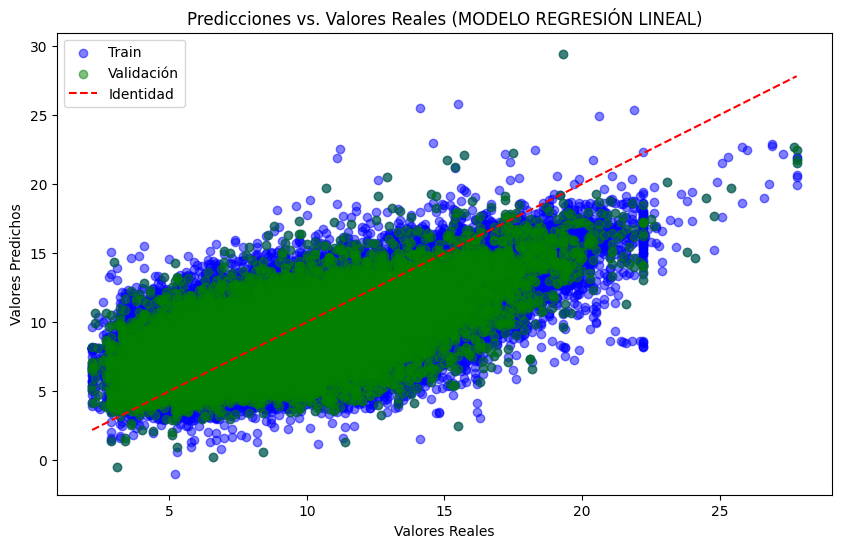

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

def Error(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evr = explained_variance_score(y_true, y_pred)
    return mae, mape, mse, rmse, r2, evr

# Entrenamiento del modelo
print("Entrenando con regresión lineal...")
model = LinearRegression()
model.fit(X_train, y_train)
print(model)

# Predicción y evaluación
print("Prediciendo valores...")
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Evaluación del modelo
maeL, mapeL, mseL, rmseL, r2L, evrL = Error(y_train, y_pred_train)
maeLT, mapeLT, mseLT, rmseLT, r2LT, evrLT = Error(y_val, y_pred_val)

print("Errores en train:")
print(f" MAE: {maeL:.4f}\n MAPE: {mapeL:.4f}\n MSE: {mseL:.4f}\n RMSE: {rmseL:.4f}\n R^2: {r2L:.4f}\n EVR: {evrL:.4f}")
print("-----------------------")

print("Errores en validación:")
print(f" MAE: {maeLT:.4f}\n MAPE: {mapeLT:.4f}\n MSE: {mseLT:.4f}\n RMSE: {rmseLT:.4f}\n R^2: {r2LT:.4f}\n EVR: {evrLT:.4f}")
print("-----------------------")

# Gráfica de Predicción vs. Valor Real
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, alpha=0.5, color='blue', label="Train")
plt.scatter(y_val, y_pred_val, alpha=0.5, color='green', label="Validación")
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', label="Identidad")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs. Valores Reales (MODELO REGRESIÓN LINEAL)")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Definir el pipeline para normalización + regresión lineal
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalizar los datos
    ('model', LinearRegression())  # Modelo de regresión
])

# Definir hiperparámetros a probar en GridSearchCV
param_grid = {
    'model__fit_intercept': [True, False],  # Probar con y sin intercepto
    'model__n_jobs': [-1]  # Utilizar todos los núcleos disponibles
}

# Configurar GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
print("Mejores Hiperparámetros:", grid.best_params_)

# Entrenar modelo con los mejores hiperparámetros
best_model = grid.best_estimator_
y_pred_val = best_model.predict(X_val)

# Evaluar con las métricas
mae, mape, mse, rmse, r2, evr = Error(y_val, y_pred_val)
print(f"Mejor Modelo - MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, EVR: {evr:.4f}")


Mejores Hiperparámetros: {'model__fit_intercept': True, 'model__n_jobs': -1}
Mejor Modelo - MAE: 1.5532, MAPE: 20.5889, MSE: 4.3562, RMSE: 2.0871, R²: 0.5184, EVR: 0.5184


# 2. Árbol de decisión

In [ ]:

print("Entrenando con Árbol de Decisión...")
model_AR = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=10)
model_AR.fit(X_train, y_train)


Entrenando con Árbol de Decisión...


DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=10)

Prediciendo valores...
Errores in train:
 MAE:1.4222
 MAPE:19.0287
 MSE: 3.6608
 RMSE: 1.9133
 R^2:0.5923
 EVR:0.5923 
-----------------------
Errores in validation:
 MAE:1.4385
 MAPE:19.2838
 MSE: 3.7419
 RMSE: 1.9344
 R^2:0.5863
 EVR:0.5863 
-----------------------


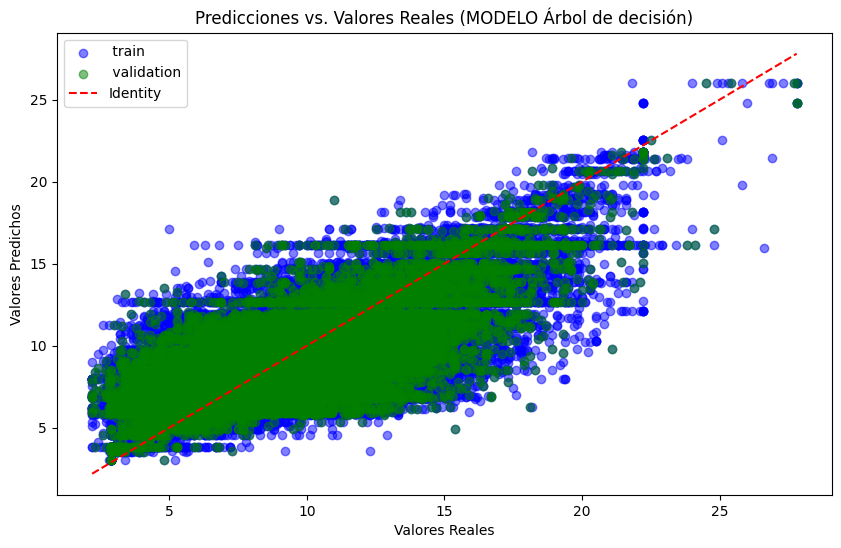

In [ ]:
if X_val is not None:
    print("Prediciendo valores...")
    y_pred4 = model_AR.predict(X_train)
    y_pred_test4 = model_AR.predict(X_val)


maeAR,mapeAR, mseAR,rmseAR, r2AR, evrAR = Error(y_train, y_pred4)
maeART,mapeART, mseART,rmseART, r2ART, evrART = Error(y_val, y_pred_test4)


print(f"Errores in train:")
print(f" MAE:{maeAR:.4f}\n MAPE:{mapeAR:.4f}\n MSE: {mseAR:.4f}\n RMSE: {rmseAR:.4f}\n R^2:{r2AR:.4f}\n EVR:{evrAR:.4f} ")
print("-----------------------")

print(f"Errores in validation:")
print(f" MAE:{maeART:.4f}\n MAPE:{mapeART:.4f}\n MSE: {mseART:.4f}\n RMSE: {rmseART:.4f}\n R^2:{r2ART:.4f}\n EVR:{evrART:.4f} ")
print("-----------------------")

# Gráfica de Predicción vs. Valor Real
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred4, alpha=0.5, color='blue' , label =" train")
plt.scatter(y_val, y_pred_test4, alpha=0.5, color='green', label =" validation")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red',label = "Identity")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs. Valores Reales (MODELO Árbol de decisión)")
plt.legend()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo
model_AR = DecisionTreeRegressor(random_seed=1)

# Definir la grilla de hiperparámetros
param_grid = {
    'max_depth': [  10, 15],
    'min_samples_split': [  10],
    'min_samples_leaf':  [ 10],
    'max_features': ['sqrt', 'log2']
}

# Búsqueda en grilla
grid_search = GridSearchCV(model_AR, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1,random_state=42)
grid_search.fit(X_train, y_train)



# Mejor combinación de hiperparámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)


# Entrenar con los mejores parámetros
best_model_AR = grid_search.best_estimator_
y_pred_best = best_model_AR.predict(X_val)

# Evaluación
mae, mape, mse, rmse, r2, evr = Error(y_val, y_pred_best)
print(f"Mejor Modelo - MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, EVR: {evr:.4f}")


Mejores Hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10}
Mejor Modelo - MAE: 1.5819, MAPE: 21.2045, MSE: 4.4961, RMSE: 2.1204, R²: 0.5029, EVR: 0.5029


# 3. Random Forest

In [ ]:
# Random Forest
import time
print("entrenando con bosque aleatorio")

model_RF = RandomForestRegressor(n_estimators=10)
inicio = time.time()
model_RF.fit(X_train, y_train)
fin = time.time()
T_total = (fin - inicio)/60
print(f"Tiempo de entrenamiento: {round(fin - inicio)} segundos")
print(f"Tiempo de entrenamiento: {T_total} minutos")

entrenando con bosque aleatorio
Tiempo de entrenamiento: 821 segundos
Tiempo de entrenamiento: 13.68254123131434 minutos


Prediciendo valores...
Erros in train:
 MAE:0.4922
 MAPE:6.5148
 MSE: 0.5501
 RMSE: 0.7417
 R^2:0.9387
 EVR:0.9387 
-----------------------
Error in validation:
 MAE:0.4983
 MAPE:6.5944
 MSE: 0.5669
 RMSE: 0.7529
 R^2:0.9373
 EVR:0.9373 
-----------------------


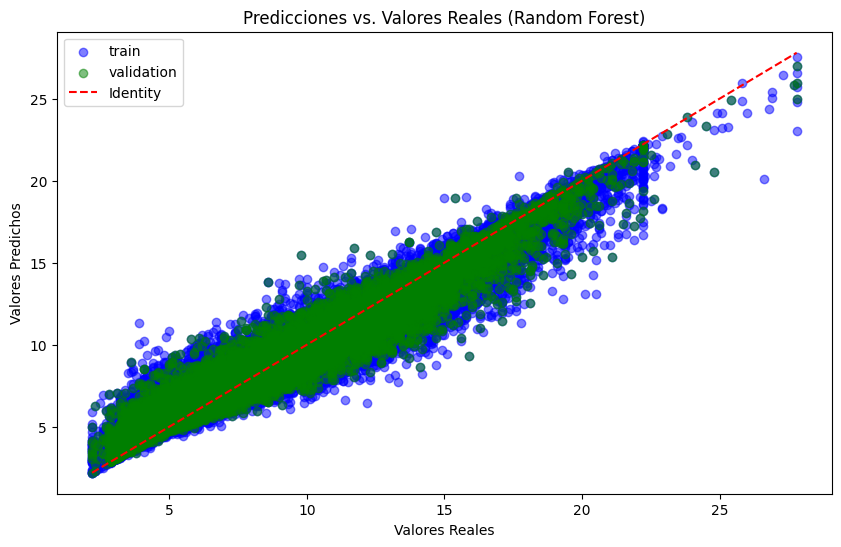

In [ ]:
# Predicción y evaluación
if X_val is not None:
    print("Prediciendo valores...")
    y_pred1 = model_RF.predict(X_train)
    y_pred_test1 = model_RF.predict(X_val)
    y_pred_test2 = model_RF.predict(test_t)

maeRF,mapeRF, mseRF,rmseRF, r2RF, evrRF = Error(y_train, y_pred1)
maeRFT,mapeRFT, mseRFT,rmseRFT, r2RFT, evrRFT = Error(y_val, y_pred_test1)
print(f"Erros in train:")
print(f" MAE:{maeRF:.4f}\n MAPE:{mapeRF:.4f}\n MSE: {mseRF:.4f}\n RMSE: {rmseRF:.4f}\n R^2:{r2RF:.4f}\n EVR:{evrRF:.4f} ")
print("-----------------------")

print(f"Error in validation:")
print(f" MAE:{maeRFT:.4f}\n MAPE:{mapeRFT:.4f}\n MSE: {mseRFT:.4f}\n RMSE: {rmseRFT:.4f}\n R^2:{r2RFT:.4f}\n EVR:{evrRFT:.4f} ")
print("-----------------------")


# Gráfica de Predicción vs. Valor Real   Randon Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred1, alpha=0.5, color='blue',label = "train")
plt.scatter(y_val, y_pred_test1, alpha=0.5, color='green',label = "validation")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red',label = "Identity")

plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs. Valores Reales (Random Forest)")
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Definir el modelo base
model_RF = RandomForestRegressor()

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [5,10],  # Cantidad de árboles
    'max_depth': [5, 10],  # Profundidad máxima del árbol
    'min_samples_split': [10],  # Tamaño mínimo para dividir nodos
    'min_samples_leaf': [ 5],  # Tamaño mínimo de hojas
    'max_features': ['sqrt', 'log2']  # Features consideradas en cada división
}

# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    model_RF, param_distributions=param_grid,
    n_iter=10, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42, verbose=2
)
### semilla global para todos


# Entrenar la búsqueda en grilla
print("Buscando mejores hiperparámetros...")
random_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores Hiperparámetros:", random_search.best_params_)

# Entrenar con los mejores parámetros
best_model_RF = random_search.best_estimator_
y_pred_best = best_model_RF.predict(X_val)

# Evaluación
mae, mape, mse, rmse, r2, evr = Error(y_val, y_pred_best)
print(f"Mejor Modelo - MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, EVR: {evr:.4f}")





Buscando mejores hiperparámetros...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores Hiperparámetros: {'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Mejor Modelo - MAE: 1.5347, MAPE: 20.8793, MSE: 4.1694, RMSE: 2.0419, R²: 0.5390, EVR: 0.5390


#4. XGBoost



In [ ]:
# Crear el modelo XGBoost
model_XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Para regresión
    n_estimators=5,  # Número de árboles si aumenta este aumenta el entrenamiento pero es mejor
    max_depth=10,       # Profundidad máxima de cada árbol
    learning_rate=0.5, # Tasa de aprendizaje ,
    random_state=42
)
inicio = time.time()
# Entrenar el modelo
model_XGB.fit(X_train, y_train)
fin = time.time()
T_total = (fin - inicio)/60
print(f"Tiempo de entrenamiento: {fin - inicio} segundos")
print(f"Tiempo de entrenamiento: {T_total} minutos")

Tiempo de entrenamiento: 24.32839059829712 segundos
Tiempo de entrenamiento: 0.4054731766382853 minutos


Prediciendo valores...
Erros in train:
 MAE:1.2482
 MAPE:16.8909
 MSE: 2.7960
 RMSE: 1.6721
 R^2:0.6886
 EVR:0.6886 
-----------------------
Error in validation:
 MAE:1.2600
 MAPE:17.0971
 MSE: 2.8450
 RMSE: 1.6867
 R^2:0.6855
 EVR:0.6855 
-----------------------


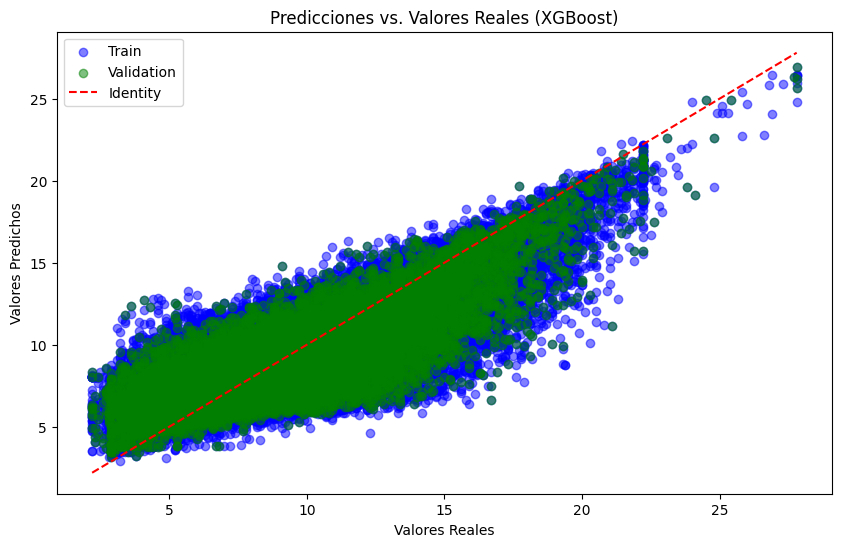

In [ ]:
# Predicción y evaluación
if X_val is not None:
    print("Prediciendo valores...")
    y_pred2 = model_XGB.predict(X_train)
    y_pred_test2 = model_XGB.predict(X_val)

maeXGB,mapeXGB, mseXGB,rmseXGB, r2XGB, evrXGB = Error(y_train, y_pred2)
maeXGBT,mapeXGBT, mseXGBT,rmseXGBT, r2XGBT, evrXGBT = Error(y_val, y_pred_test2)

print(f"Erros in train:")
print(f" MAE:{maeXGB:.4f}\n MAPE:{mapeXGB:.4f}\n MSE: {mseXGB:.4f}\n RMSE: {rmseXGB:.4f}\n R^2:{r2XGB:.4f}\n EVR:{evrXGB:.4f} ")
print("-----------------------")

print(f"Error in validation:")
print(f" MAE:{maeXGBT:.4f}\n MAPE:{mapeXGBT:.4f}\n MSE: {mseXGBT:.4f}\n RMSE: {rmseXGBT:.4f}\n R^2:{r2XGBT:.4f}\n EVR:{evrXGBT:.4f} ")
print("-----------------------")

# Gráfica de Predicción vs. Valor Real   Randon Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred2, alpha=0.5, color='blue', label = "Train")
plt.scatter(y_val, y_pred_test2, alpha=0.5, color='green',label = "Validation")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red',label = "Identity")
plt.legend()
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs. Valores Reales (XGBoost)")
plt.show()




In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Crear el modelo base XGBoost
model_XGB = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [6, 10],
    'learning_rate': [0.3,0.5]
}

# Configurar `GridSearchCV`
grid_search = GridSearchCV(
    estimator=model_XGB,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,  # Validación cruzada con 3 folds
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=2
)

# Ejecutar la búsqueda en grilla
print("Buscando los mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores Hiperparámetros:", grid_search.best_params_)

# Entrenar el mejor modelo encontrado
best_model_XGB = grid_search.best_estimator_
y_pred_best = best_model_XGB.predict(X_val)

# Evaluación del mejor modelo
mae, mape, mse, rmse, r2, evr = Error(y_val, y_pred_best)
print(f"Mejor Modelo - MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, EVR: {evr:.4f}")


Buscando los mejores hiperparámetros...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores Hiperparámetros: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 10}
Mejor Modelo - MAE: 1.4514, MAPE: 19.5619, MSE: 3.7977, RMSE: 1.9488, R²: 0.5801, EVR: 0.5801


# 5. Red Neuronal


In [ ]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# RED NEURONAL
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#  Modelo TabNet
model_RN = TabNetRegressor(verbose=1)

y_train_ = y_train.values.reshape(-1, 1) # Reshape to 2D for TabNetRegressor
y_val_ = y_val.values.reshape(-1, 1)
# Entrenar modelo
model_RN.fit(
    X_train, y_train_,  # Datos de entrenamiento
    eval_set=[(X_val, y_val_)],    # Datos de validación
    eval_metric=['rmse'],         # Métrica de evaluación
    max_epochs=5,               # Máximas épocas de entrenamiento
    patience=10,                  # Parada temprana si no mejora
    batch_size=1024,              # Tamaño del lote
)

epoch 0  | loss: 10.4242 | val_0_rmse: 2.41384 |  0:00:58s
epoch 1  | loss: 5.52971 | val_0_rmse: 2.33805 |  0:01:55s
epoch 2  | loss: 5.44493 | val_0_rmse: 2.3297  |  0:02:53s
epoch 3  | loss: 5.32528 | val_0_rmse: 2.29549 |  0:03:51s
epoch 4  | loss: 4.74335 | val_0_rmse: 2.08755 |  0:04:48s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_rmse = 2.08755


Prediciendo valores...
(177024, 1)
(35405, 1)
Erros in train:
 MAE:1.5432
 MAPE:21.0279
 MSE: 4.2680
 RMSE:2.0659
 R^2:0.5246
 EVR:0.5275 
-----------------------
Error in validation:
 MAE:1.5627
 MAPE:21.3102
 MSE: 4.3579
 RMSE:2.0875
 R^2:0.5182
 EVR:0.5210 
-----------------------


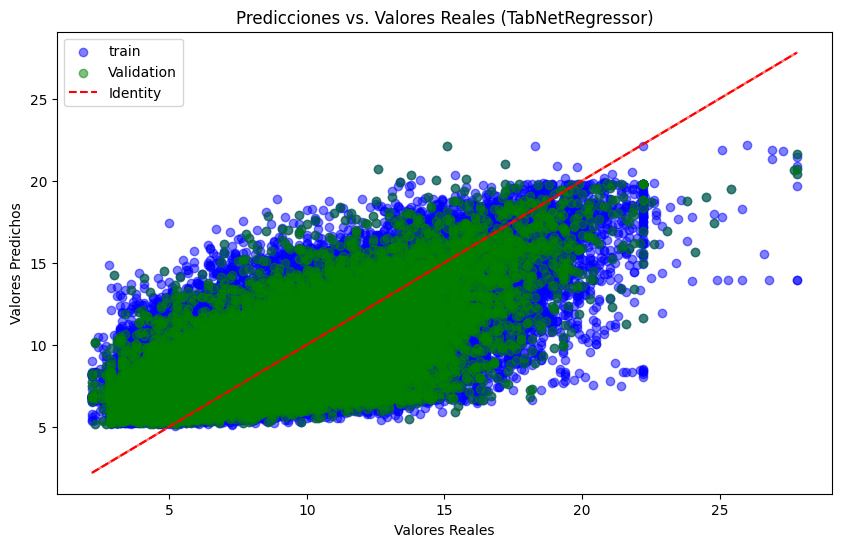

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predicción y evaluación
if X_val is not None:
    print("Prediciendo valores...")
    y_pred3 = model_RN.predict(X_train)
    y_pred_test3 = model_RN.predict(X_val)
    print(y_pred3.shape)
    print(y_pred_test3.shape)

maeRN,mapeRN, mseRN,rmseRN, r2RN, evrRN = Error(y_train_, y_pred3)
maeRNT,mapeRNT, mseRNT,rmseRNT, r2XRNT, evrRNT = Error(y_val_, y_pred_test3)

print(f"Erros in train:")
print(f" MAE:{maeRN:.4f}\n MAPE:{mapeRN:.4f}\n MSE: {mseRN:.4f}\n RMSE:{rmseRN:.4f}\n R^2:{r2RN:.4f}\n EVR:{evrRN:.4f} ")
print("-----------------------")

print(f"Error in validation:")
print(f" MAE:{maeRNT:.4f}\n MAPE:{mapeRNT:.4f}\n MSE: {mseRNT:.4f}\n RMSE:{rmseRNT:.4f}\n R^2:{r2XRNT:.4f}\n EVR:{evrRNT:.4f} ")
print("-----------------------")

# Gráfica de Predicción vs. Valor Real   Randon Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred3, alpha=0.5, color='blue',label = "train")
plt.scatter(y_val, y_pred_test3, alpha=0.5, color='green',label = "Validation")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red',label="Identity")
plt.plot(y_val,y_val, alpha = 0.5, color = 'red')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Predicciones vs. Valores Reales (TabNetRegressor)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor
import numpy as np

# Definir una función para crear y devolver el modelo
def create_tabnet(n_d, n_a, n_steps, gamma, lambda_sparse):
    return TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        verbose=1  # Mostrar progreso sin saturar
    )

# Definir la grilla de hiperparámetros
param_grid = {
    'n_d': [8, 16],
    'n_a': [8],
    'n_steps': [3, 5],
    'gamma': [1.3, 1.5],
    'lambda_sparse': [0.001, 0.01]
}

# Convertir etiquetas a formato adecuado (evita errores)
y_train_ = y_train.values.reshape(-1, 1)
y_val_ = y_val.values.reshape(-1, 1)

# Variables para guardar el mejor modelo
best_score = float('inf')
best_params = None

# Búsqueda manual en grilla
for n_d in param_grid['n_d']:
    for n_a in param_grid['n_a']:
        for n_steps in param_grid['n_steps']:
            for gamma in param_grid['gamma']:
                for lambda_sparse in param_grid['lambda_sparse']:
                    print(f"\n🔍 Probando con: n_d={n_d}, n_a={n_a}, n_steps={n_steps}, gamma={gamma}, lambda_sparse={lambda_sparse}")

                    try:
                        # Crear y entrenar el modelo
                        model = create_tabnet(n_d, n_a, n_steps, gamma, lambda_sparse)
                        model.fit(
                            X_train, y_train_,
                            eval_set=[(X_val, y_val_)],
                            eval_metric=['rmse'],
                            max_epochs=5,
                            patience=10,
                            batch_size=1024,
                        )

                        # Evaluar el modelo
                        y_pred = model.predict(X_val)
                        mse = mean_squared_error(y_val, y_pred)

                        # Guardar el mejor modelo
                        if mse < best_score:
                            best_score = mse
                            best_params = {
                                'n_d': n_d, 'n_a': n_a, 'n_steps': n_steps,
                                'gamma': gamma, 'lambda_sparse': lambda_sparse
                            }

                        print(f"✅ MSE obtenido: {mse:.4f}")

                    except Exception as e:
                        print(f"⚠️ Error con esta combinación: {e}")

# Imprimir los mejores hiperparámetros encontrados
print("\n🎯 Mejores Hiperparámetros:", best_params)

# Entrenar el mejor modelo encontrado
if best_params:
    best_model = create_tabnet(**best_params)
    best_model.fit(
        X_train, y_train_,
        eval_set=[(X_val, y_val_)],
        eval_metric=['rmse'],
        max_epochs=5,
        patience=10,
        batch_size=1024,
    )

    # Predicción y evaluación del mejor modelo
    y_pred_best = best_model.predict(X_val)
    mae, mape, mse, rmse, r2, evr = Error(y_val, y_pred_best)

    print(f"\n🔹 **Mejor Modelo - Métricas:**")
    print(f" MAE: {mae:.4f}, MAPE: {mape:.4f}, MSE: {mse:.4f}")
    print(f" RMSE: {rmse:.4f}, R²: {r2:.4f}, EVR: {evr:.4f}")
else:
    print("❌ No se encontró una combinación válida de hiperparámetros.")



🔍 Probando con: n_d=8, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=0.001
epoch 0  | loss: 9.78574 | val_0_rmse: 2.3254  |  0:00:39s
epoch 1  | loss: 4.59773 | val_0_rmse: 2.1526  |  0:01:18s
epoch 2  | loss: 4.51541 | val_0_rmse: 2.1111  |  0:01:55s
epoch 3  | loss: 4.37674 | val_0_rmse: 2.07813 |  0:02:34s
epoch 4  | loss: 4.26928 | val_0_rmse: 2.05701 |  0:03:19s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_rmse = 2.05701
✅ MSE obtenido: 4.2313

🔍 Probando con: n_d=8, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=0.01
epoch 0  | loss: 9.61455 | val_0_rmse: 2.19726 |  0:00:39s
epoch 1  | loss: 4.69214 | val_0_rmse: 2.1347  |  0:01:17s
epoch 2  | loss: 4.50984 | val_0_rmse: 2.13034 |  0:01:55s
epoch 3  | loss: 4.39914 | val_0_rmse: 2.07767 |  0:02:33s
epoch 4  | loss: 4.30902 | val_0_rmse: 2.07978 |  0:03:12s
Stop training because you reached max_epochs = 5 with best_epoch = 3 and best_val_0_rmse = 2.07767
✅ MSE obtenido: 4.3167

🔍 Probando con: n_d=

ValueError: Las dimensiones de y_real y y_pred no coinciden.

# Graficas


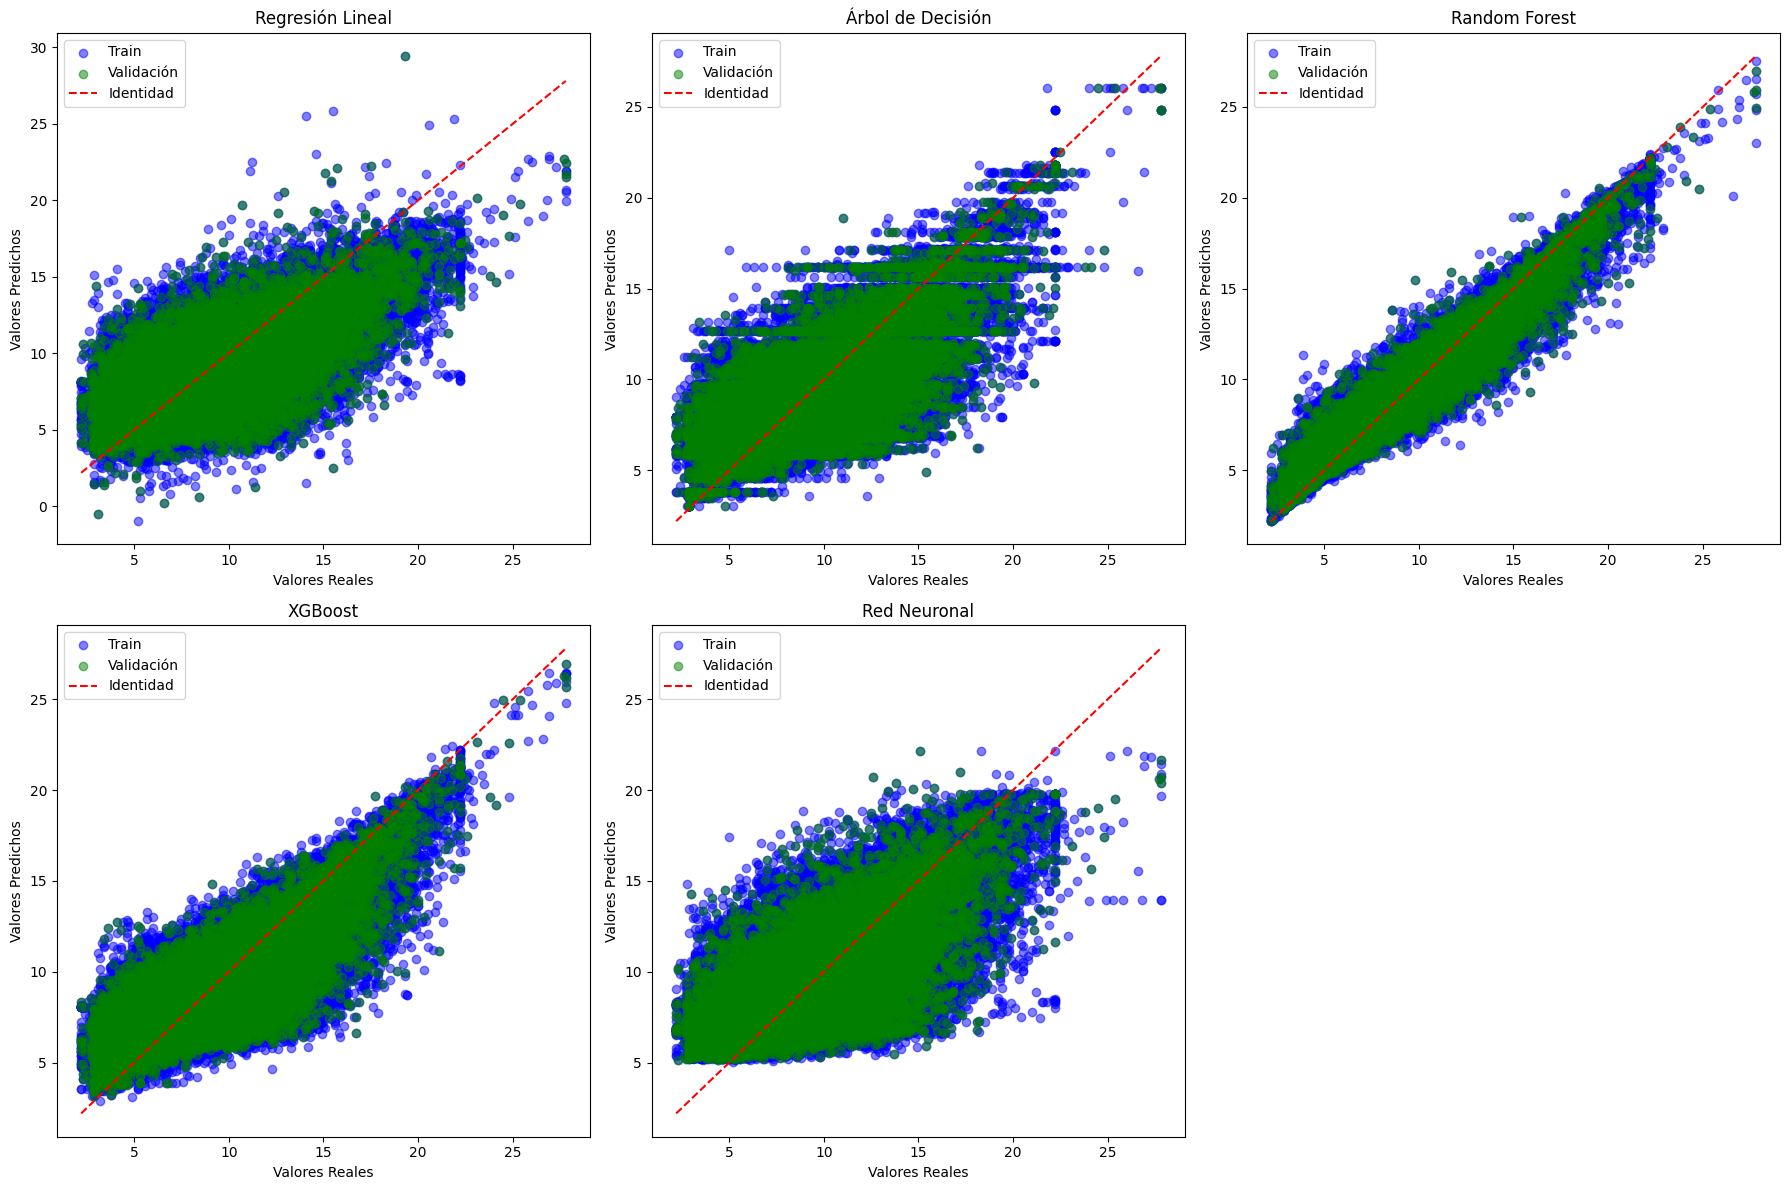

In [ ]:

# Subplots para comparaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Subplot 1: Regresión Lineal
axes[0, 0].scatter(y_train, y_pred_train, alpha=0.5, color='blue', label="Train")
axes[0, 0].scatter(y_val, y_pred_val, alpha=0.5, color='green', label="Validación")
axes[0, 0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', label="Identidad")
axes[0, 0].set_title("Regresión Lineal")
axes[0, 0].set_xlabel("Valores Reales")
axes[0, 0].set_ylabel("Valores Predichos")
axes[0, 0].legend()

# Subplot 2: Árbol de Decisión
axes[0, 1].scatter(y_train, y_pred4, alpha=0.5, color='blue', label="Train")
axes[0, 1].scatter(y_val, y_pred_test4, alpha=0.5, color='green', label="Validación")
axes[0, 1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', label="Identidad")
axes[0, 1].set_title("Árbol de Decisión")
axes[0, 1].set_xlabel("Valores Reales")
axes[0, 1].set_ylabel("Valores Predichos")
axes[0, 1].legend()

# Subplot 3: Random Forest
axes[0, 2].scatter(y_train, y_pred1, alpha=0.5, color='blue', label="Train")
axes[0, 2].scatter(y_val, y_pred_test1, alpha=0.5, color='green', label="Validación")
axes[0, 2].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', label="Identidad")
axes[0, 2].set_title("Random Forest")
axes[0, 2].set_xlabel("Valores Reales")
axes[0, 2].set_ylabel("Valores Predichos")
axes[0, 2].legend()

# Subplot 4: XGBoost
axes[1, 0].scatter(y_train, y_pred2, alpha=0.5, color='blue', label="Train")
axes[1, 0].scatter(y_val, y_pred_test2, alpha=0.5, color='green', label="Validación")
axes[1, 0].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', label="Identidad")
axes[1, 0].set_title("XGBoost")
axes[1, 0].set_xlabel("Valores Reales")
axes[1, 0].set_ylabel("Valores Predichos")
axes[1, 0].legend()

# Subplot 5: Red Neuronal
axes[1, 1].scatter(y_train, y_pred3, alpha=0.5, color='blue', label="Train")
axes[1, 1].scatter(y_val, y_pred_test3, alpha=0.5, color='green', label="Validación")
axes[1, 1].plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red', label="Identidad")
axes[1, 1].set_title("Red Neuronal")
axes[1, 1].set_xlabel("Valores Reales")
axes[1, 1].set_ylabel("Valores Predichos")
axes[1, 1].legend()

# Ocultar subplot vacío
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


3
